# Reproducing the models of Spitoni et al. (2024)

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import vice
import paths
from track_and_mdf import setup_figure, plot_vice_onezone
from utils import Exponential

In [2]:
output_dir = paths.data / 'onezone' / 'Spitoni2024'
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
plt.style.use(paths.styles / 'paper.mplstyle')
plt.rcParams['figure.dpi'] = 200

Yields: the tables of Francois et al. (2004) don't change the values for Fe or O from their original sources, Woosley & Weaver (1995) and Iwamoto et al. (1999, model W7).

In [4]:
from multizone.src.yields import F04

SN Ia DTD: I think they use a SD model similar to Greggio (2005)

In [5]:
from multizone.src.dtds import greggio05_single
SD_RIa = greggio05_single()

## The Massive Dwarf Model

In [35]:
# As in Vincenzo et al. (2019), normalize infall to accrete a total of 10^10 Msun
dwarf_ifr = Exponential(scale=-0.24, coeff=1e10/0.24)
dwarf_ifr.coeff *= 1e-9 # convert to Msun/yr
dt = 0.01
dwarf_simtime = np.arange(0, 3.8+dt, dt)

dwarf = vice.singlezone(
    name=str(output_dir / 'dwarf'),
    func=dwarf_ifr,
    mode='ifr',
    elements=('fe', 'o', 'mg', 'si'),
    eta=1.5,
    delay=0.04,
    RIa=SD_RIa,
    Mg0=1e6,
    tau_star=1/0.42,
    dt=dt,
    # schmidt=True,
    # schmidt_index=1.,
    # MgSchmidt=1e10,
    bins=[i*0.01 - 3 for i in range(401)],
)
dwarf.run(dwarf_simtime, overwrite=True)

In [36]:
dwarf_hist = vice.history(str(output_dir / 'dwarf'))
dwarf_hist
# print(dwarf_hist)
# dwarf_hist = dwarf_hist.todict()
# dwarf_hist['[a/fe]'] = [dwarf_hist['[mg/fe]'][i] + dwarf_hist['[si/fe]'][i] for i in range(len(dwarf_hist['time']))]
# print(dwarf_hist['[a/fe]'])

vice.dataframe{
    time -----------> [0, 0.01, 0.02, ... , 3.79, 3.8, 3.81]
    mgas -----------> [1e+06, 4.17657e+08, 8.13102e+08, ... , 5.07084e+08, 5.03266e+08, 4.9948e+08]
    mstar ----------> [0, 3797.76, 1.58975e+06, ... , 2.84662e+09, 2.84724e+09, 2.84786e+09]
    sfr ------------> [0.00042, 0.175416, 0.341503, ... , 0.212975, 0.211372, 0.209782]
    ifr ------------> [41.6667, 39.9662, 38.3352, ... , 5.77504e-06, 5.53936e-06, 5.31329e-06]
    ofr ------------> [0.000680312, 0.263124, 0.512254, ... , 0.319463, 0.317057, 0.314672]
    eta_0 ----------> [1.5, 1.5, 1.5, ... , 1.5, 1.5, 1.5]
    r_eff ----------> [0.0957713, 0.0958878, 0.120796, ... , 0.707073, 0.708804, 0.710539]
    z_in(fe) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(o) --------> [0, 0, 0, ... , 0, 0, 0]
    z_in(mg) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(si) -------> [0, 0, 0, ... , 0, 0, 0]
    z_out(fe) ------> [1.01605e-313, 4.3651e-06, 4.3772e-06, ... , 0.00437226, 0.00438983, 0.0044074]
    z_out(o) --

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


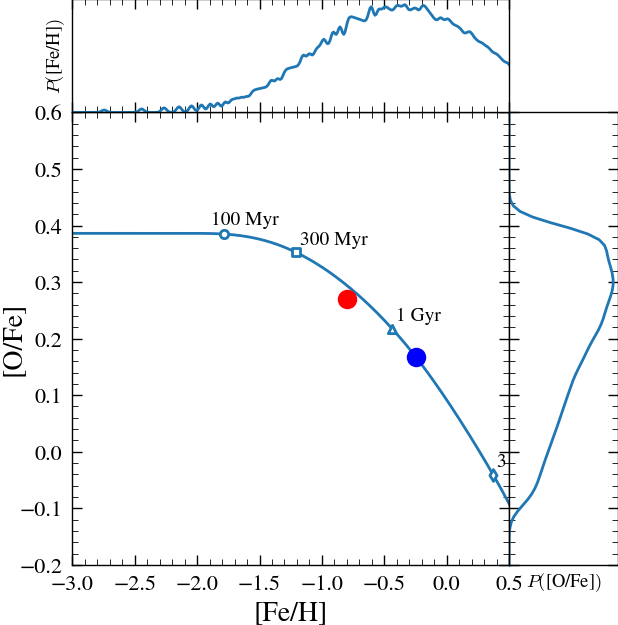

In [37]:
fig, axs = setup_figure(xlim=(-3, 0.5), ylim=(-0.2, 0.6))

plot_vice_onezone(str(output_dir / 'dwarf'), 
                  fig=fig, axs=axs,
                  label='',
                  marker_labels=True,
                  ycol='[o/fe]')
axs[0].plot(-0.8, 0.27, 'ro')
tdisk = 1.3
axs[0].plot(dwarf_hist['[fe/h]'][int(tdisk*100)], dwarf_hist['[o/fe]'][int(tdisk*100)], 'bo')

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left')
plt.show()

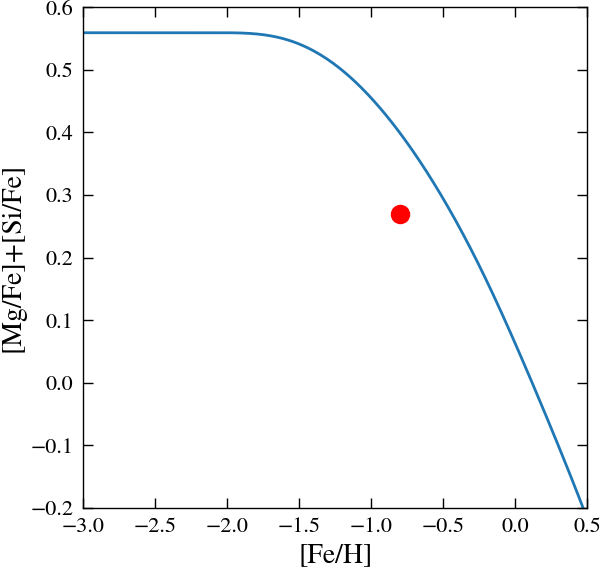

In [38]:
fig, ax = plt.subplots()
ax.plot(dwarf_hist['[fe/h]'], np.array(dwarf_hist['[mg/fe]']) + np.array(dwarf_hist['[si/fe]']))
ax.plot(-0.8, 0.27, 'ro')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Mg/Fe]+[Si/Fe]')
ax.set_xlim(-3, 0.5)
ax.set_ylim(-0.2, 0.6)
plt.show()

In [9]:
dwarf_mdf = vice.mdf(str(output_dir / 'dwarf'))
dwarf_mdf

vice.dataframe{
    bin_edge_left --> [-3, -2.99, -2.98, ... , 0.97, 0.98, 0.99]
    bin_edge_right -> [-2.99, -2.98, -2.97, ... , 0.98, 0.99, 1]
    dn/d[fe/h] -----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[o/h] ------> [0, 0, 0, ... , 0, 0, 0]
    dn/d[o/fe] -----> [0, 0, 0, ... , 0, 0, 0]
}

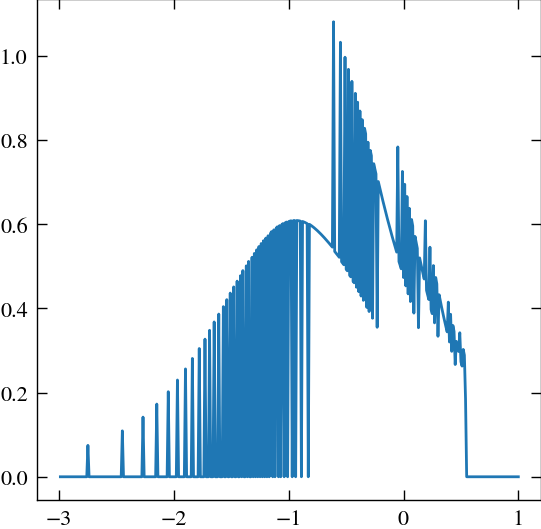

In [10]:
plt.plot(dwarf_mdf['bin_edge_right'], dwarf_mdf['dn/d[fe/h]'])
plt.show()

The Two-Infall Model

In [11]:
dt = 0.01
tmax = 12.5
simtime = np.arange(0, tmax+dt, dt)

In [12]:
class TwoInfall(OneInfall):
    def __init__(self, timescale1=0.377, timescale2=3.203, amplitude1=1, onset=3.519, present_mass_ratio=2.5, tmax=12.5):
        self.onset = onset
        # Calculate the amplitude ratio (second infall to first)
        amp_ratio = present_mass_ratio 
        amp_ratio *= timescale1 * (1 - m.exp(-tmax/timescale1))
        amp_ratio *= 1 / (timescale2 * (1 - m.exp(-(tmax - onset)/timescale2)))
        self.infall1 = OneInfall(timescale=timescale1, amplitude=amplitude1)
        self.infall2 = OneInfall(timescale=timescale2, amplitude=amp_ratio*amplitude1)
    
    def __call__(self, time):
        if time < self.onset:
            return self.infall1(time)
        else:
            return self.infall1(time) + self.infall2(time - self.onset)

fig, ax = plt.subplots()
twoinfall_ifr = TwoInfall()
ifr_data = np.array([twoinfall_ifr(t) for t in simtime])
ax.plot(simtime, ifr_data)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('Infall Rate')
plt.show()

NameError: name 'OneInfall' is not defined